In [1]:
import pandas as pd
import numpy as np
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import string
import random
import string
from sklearn import linear_model
import os
import matplotlib.pyplot as plt

# The Data

In [16]:
# load the data
def readFiles(file):
    file_path = os.path.join('data', file)
    return pd.read_csv(file_path, compression='gzip')

trainData = readFiles('interactions_train.csv.gz')
validData = readFiles('interactions_validation.csv.gz')
testData = readFiles('interactions_test.csv.gz')
recipes = readFiles('RAW_recipes.csv.gz')
interactions = readFiles('RAW_interactions.csv.gz')

In [4]:
trainData.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [5]:
print(trainData.head().to_markdown(index=False))

|   user_id |   recipe_id | date       |   rating |     u |      i |
|----------:|------------:|:-----------|---------:|------:|-------:|
|      2046 |        4684 | 2000-02-25 |        5 | 22095 |  44367 |
|      2046 |         517 | 2000-02-25 |        5 | 22095 |  87844 |
|      1773 |        7435 | 2000-03-13 |        5 | 24732 | 138181 |
|      1773 |         278 | 2000-03-13 |        4 | 24732 |  93054 |
|      2046 |        3431 | 2000-04-07 |        5 | 22095 | 101723 |


In [6]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


# EDA

`recipes` data

In [7]:
# Display basic information
print("Recipes Data Info:")
print(recipes.info())

Recipes Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB
None


In [8]:
print(recipes.describe().to_markdown())

|       |     id |          minutes |   contributor_id |      n_steps |   n_ingredients |
|:------|-------:|-----------------:|-----------------:|-------------:|----------------:|
| count | 231637 | 231637           | 231637           | 231637       |    231637       |
| mean  | 222015 |   9398.55        |      5.53489e+06 |      9.7655  |         9.05115 |
| std   | 141207 |      4.46196e+06 |      9.97914e+07 |      5.99513 |         3.7348  |
| min   |     38 |      0           |     27           |      0       |         1       |
| 25%   |  99944 |     20           |  56905           |      6       |         6       |
| 50%   | 207249 |     40           | 173614           |      9       |         9       |
| 75%   | 333816 |     65           | 398275           |     12       |        11       |
| max   | 537716 |      2.14748e+09 |      2.00229e+09 |    145       |        43       |


First descriptive statistics of `recipes`


|       |     id |          minutes |   contributor_id |      n_steps |   n_ingredients |
|:------|-------:|-----------------:|-----------------:|-------------:|----------------:|
| count | 231637 | 231637           | 231637           | 231637       |    231637       |
| mean  | 222015 |   9398.55        |      5.53489e+06 |      9.7655  |         9.05115 |
| std   | 141207 |      4.46196e+06 |      9.97914e+07 |      5.99513 |         3.7348  |
| min   |     38 |      0           |     27           |      0       |         1       |
| 25%   |  99944 |     20           |  56905           |      6       |         6       |
| 50%   | 207249 |     40           | 173614           |      9       |         9       |
| 75%   | 333816 |     65           | 398275           |     12       |        11       |
| max   | 537716 |      2.14748e+09 |      2.00229e+09 |    145       |        43       |

In [11]:
# Check for missing values
print("Missing Values in Recipes Data:")
print(recipes.isnull().sum())

Missing Values in Recipes Data:
name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64


In [12]:
# Unique values
print("Unique Values in Key Columns - Recipes:")
print(recipes.nunique())

Unique Values in Key Columns - Recipes:
name              230185
id                231637
minutes              888
contributor_id     27926
submitted           5090
tags              209115
nutrition         229318
n_steps               94
steps             231074
description       222668
ingredients       230475
n_ingredients         41
dtype: int64


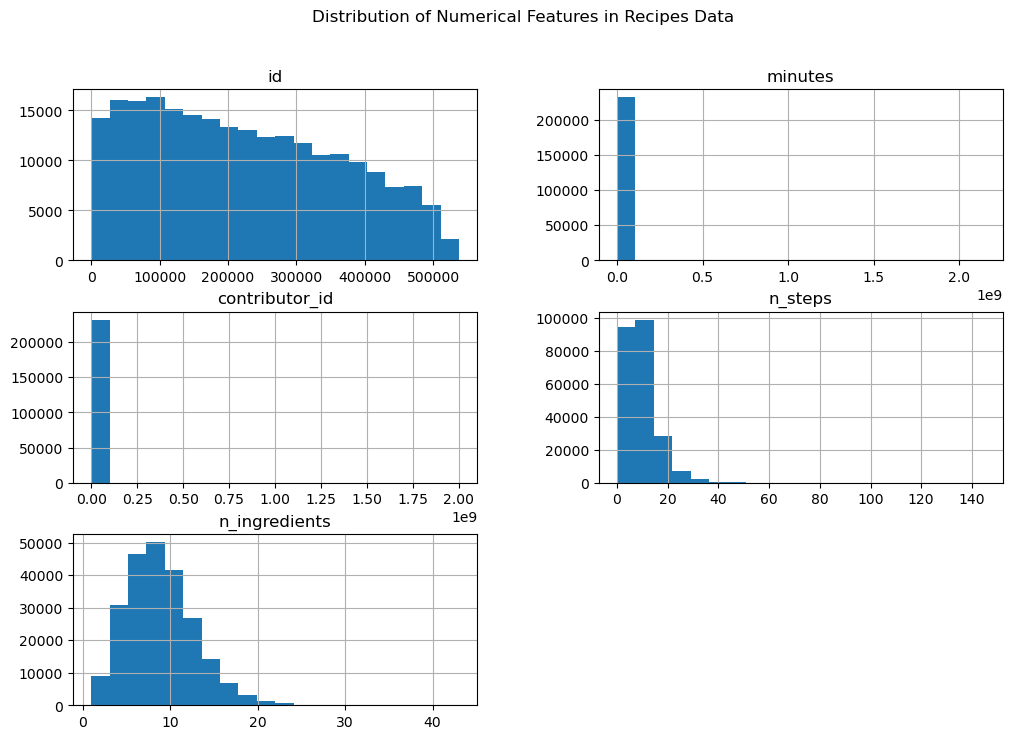

In [13]:
# Plot distributions of numeric columns in recipes
recipes.hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribution of Numerical Features in Recipes Data")
plt.show()

In [14]:
# Most common ingredients:
print("Most Common Ingredients:")
print(recipes['ingredients'].value_counts().head(10))

Most Common Ingredients:
['eggs', 'water']                                                                                                                              10
['flour', 'baking powder', 'salt', 'shortening', 'milk']                                                                                        6
['sugar', 'water']                                                                                                                              5
['butter', 'sugar', 'flour']                                                                                                                    5
['all-purpose flour', 'baking powder', 'salt', 'butter', 'milk']                                                                                5
['lemons', 'limes', 'oranges', 'water', 'sugar']                                                                                                5
['butter', 'honey']                                                                                

`interactions` data

In [17]:
print("\nInteractions Data Info:")
print(interactions.info())


Interactions Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB
None


In [18]:
# Check for missing values
print("\nMissing Values in Interactions Data:")
print(interactions.isnull().sum())


Missing Values in Interactions Data:
user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64


In [19]:
# Unique values
print("\nUnique Values in Key Columns - Interactions:")
print(interactions.nunique())


Unique Values in Key Columns - Interactions:
user_id       226570
recipe_id     231637
date            6396
rating             6
review       1125282
dtype: int64


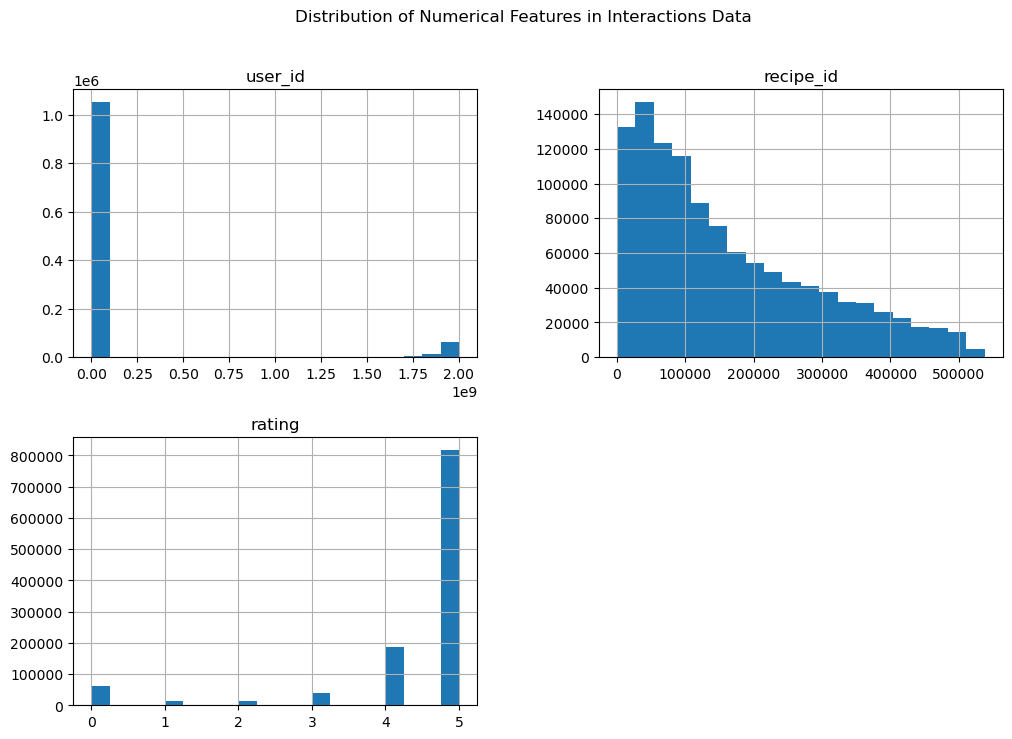

In [20]:
# Plot distributions of numeric columns in interactions
interactions.hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribution of Numerical Features in Interactions Data")
plt.show()

Rating Distribution:
5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64


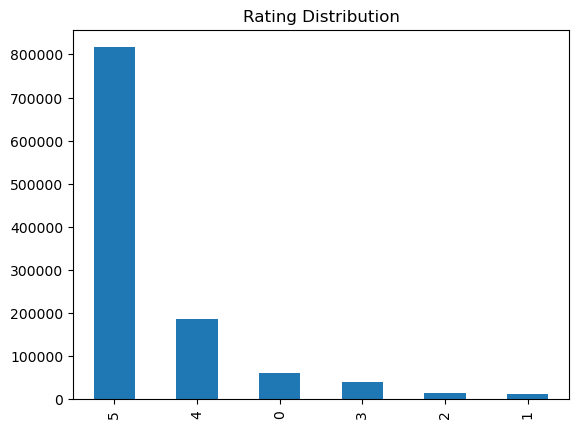

In [21]:
# Distribution of ratings
print("Rating Distribution:")
print(interactions['rating'].value_counts())
interactions['rating'].value_counts().plot(kind='bar')
plt.title("Rating Distribution")
plt.show()